In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [2]:
plt.rc("figure", dpi=150)
np.random.seed(123)

<Axes: xlabel='temperature', ylabel='rented'>

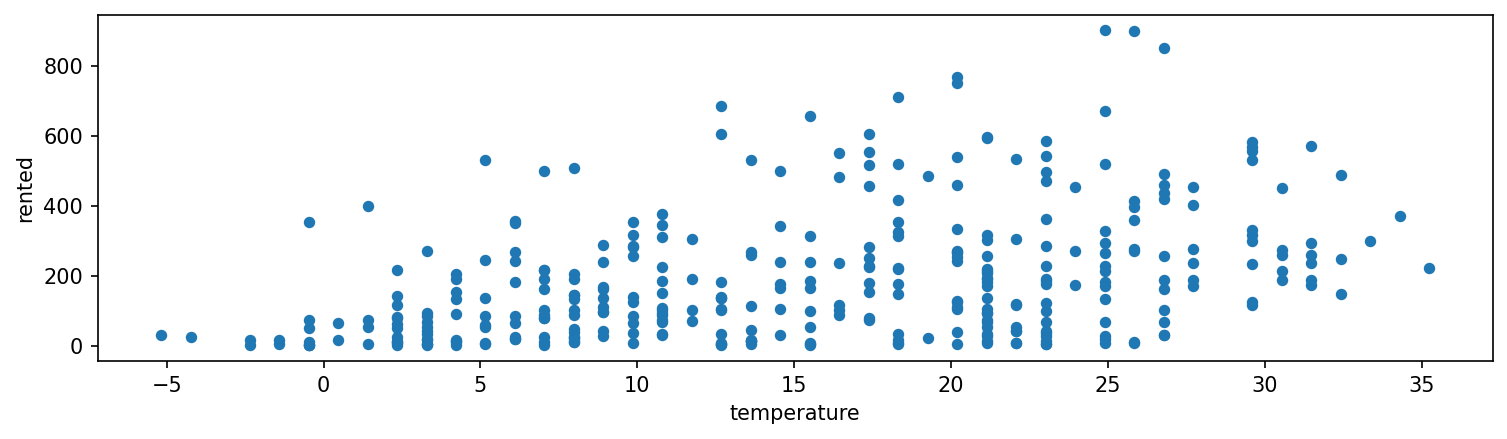

In [4]:
bikes = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [10]:
coords = {"data": np.arange(len(bikes))}
with pm.Model(coords=coords) as model_lb:
    β0 = pm.Normal("β0", mu=0, sigma=100)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", β0 + β1 * bikes.temperature, dims="data")
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented, dims="data")
    

In [11]:
idata_lb = pm.sample(random_seed=123, model=model_lb)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [12]:
idata_lb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'β0'}>, <Axes: title={'center': 'β1'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

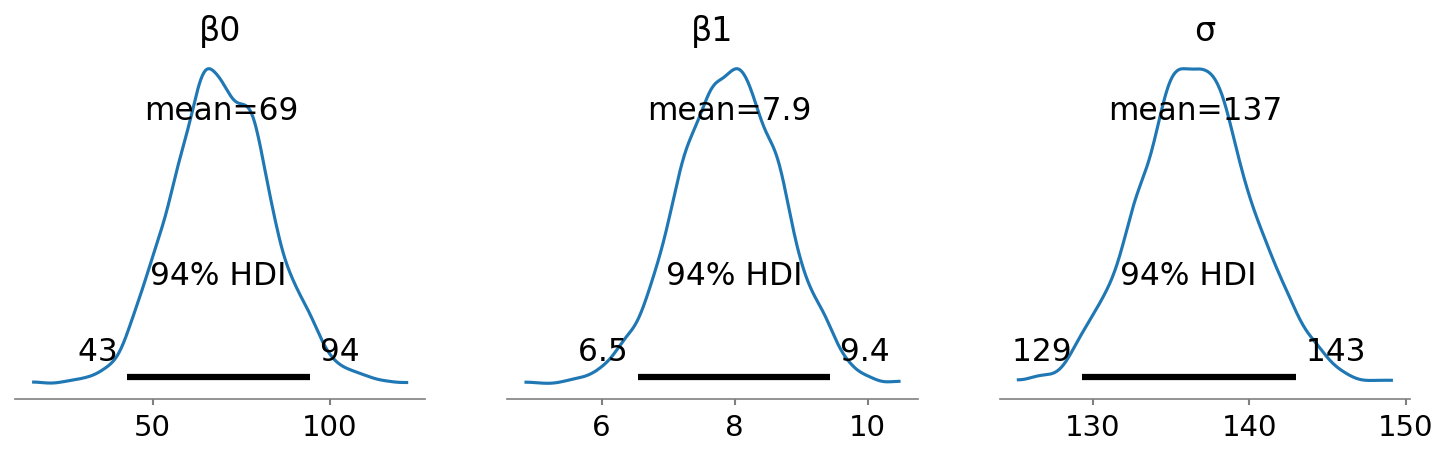

In [13]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

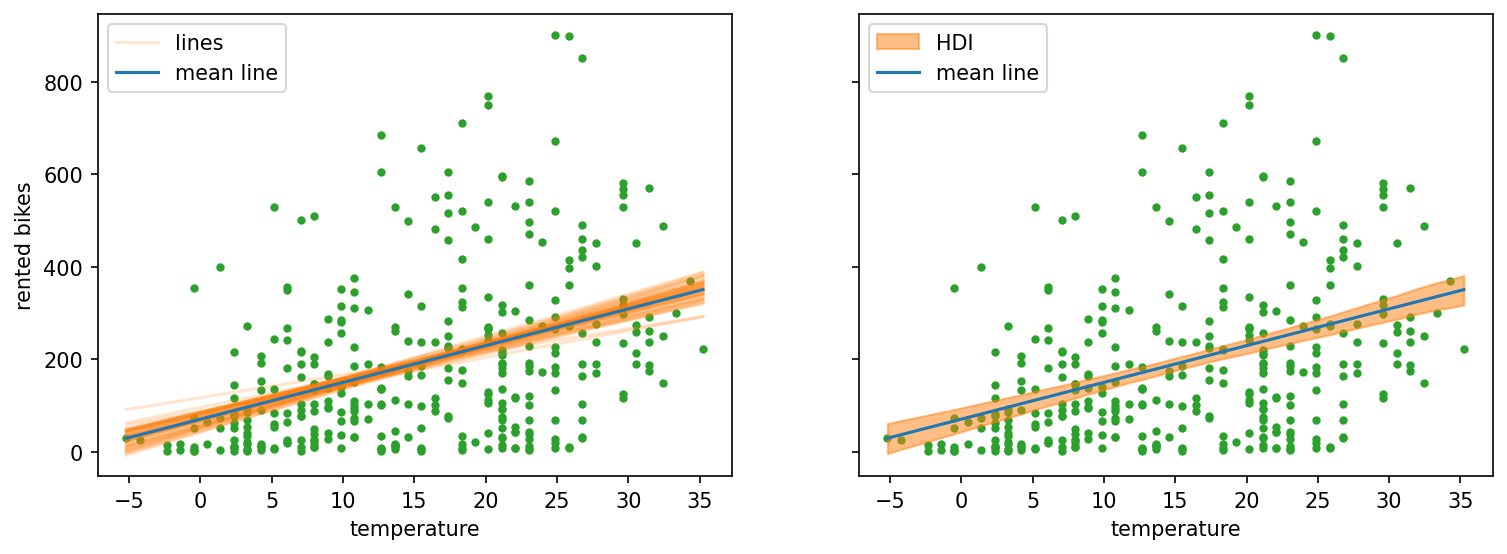

In [14]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)
mean_line = posterior["β0"].mean() + posterior["β1"].mean() * x_plot
lines = posterior["β0"] + posterior["β1"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()

In [15]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'rented bikes')

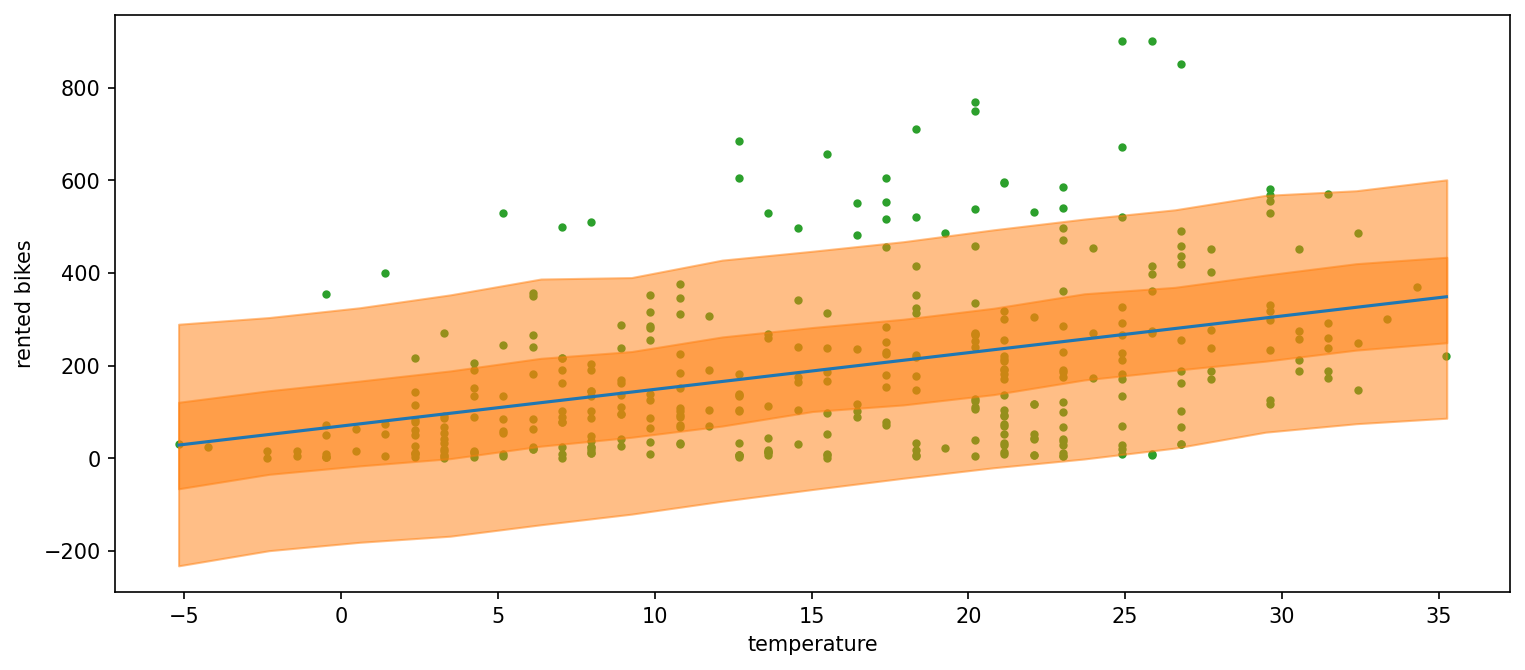

In [16]:
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")